# Build the Classifier
This notebook is dedicated to creating classifiers and run classification analyses of interest on neuroimaging data.

Can we accurately classify:
- adults vs. children across conditions
- adults versus children within each condition

Can we predict:
- child age based on multivariate patterns of brain activation
- child age based on brain activation in each condition

In [1]:
from pandas import DataFrame, Series, read_csv

# Study specific variables
study_home = '/home/camachocm2/Analysis/KidVid_MVPA'
standard_mask = study_home + '/template/MNI152_T1_2mm_brain_mask_KV.nii.gz'
gm_mask = study_home + '/template/gm_2mm_mask.nii.gz'
template = study_home + '/template/MNI152_T1_1mm_brain.nii.gz'
sub_data_file = study_home + '/doc/subjectinfo.csv'
preproc_dir = study_home + '/analysis/preproc/betas'
output_dir = study_home + '/analysis/classifier'

condition_data = read_csv(study_home + '/doc/conditionslist.csv')
subject_info = read_csv(sub_data_file, index_col=0)
subject_info.describe()

,age_mos,age_yrs,CBCL_intern,CBCL_extern,MAPDB_temploss,CBQ_Anger_Frustration,CBQ_Activity_Level,CBQ_Approach_Positive_Anticipation,CBQ_Attentional_ Focusing,CBQ_Discomfort,...,CBQ_Low_ Intensity_ Pleasure,CBQ_Perceptual_ Sensitivity,CBQ_Sadness,CBQ_Shyness,CBQ_Smiling_Laughter,age_mos_std,MAPDB_temploss_std,CBQ_Anger_Frustration_std,CBCL_intern_std,CBCL_extern_std
count,51.000000,51.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01
mean,186.007843,15.137255,5.233333,5.366667,12.233333,4.541270,3.883444,4.994555,4.933222,4.022220,...,5.258333,5.094445,3.971604,3.716889,5.377889,6.666682e-12,-3.333334e-12,-3.333319e-12,3.333327e-12,3.333339e-12
std,119.838533,10.282061,5.969366,6.183869,7.933705,1.017132,0.981753,0.957611,1.168547,1.190428,...,1.398095,1.252341,1.068094,1.450841,1.171197,1.017095e+00,1.017095e+00,1.017095e+00,1.017095e+00,1.017095e+00
min,58.000000,4.000000,0.000000,0.000000,0.000000,2.285714,2.000000,2.833333,2.833333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.648830e+00,-1.568304e+00,-2.255473e+00,-8.916857e-01,-8.826855e-01
25%,86.150000,6.000000,1.000000,1.250000,5.250000,3.857143,3.083333,4.208333,4.041667,3.500000,...,4.562500,4.666667,3.750000,2.667500,5.000000,-8.812385e-01,-8.952583e-01,-6.841020e-01,-7.212999e-01,-6.770911e-01
50%,122.100000,10.000000,3.000000,4.000000,11.500000,4.500000,3.668333,5.000000,5.000000,4.000000,...,5.625000,5.333333,4.142857,3.916667,5.583333,-9.481084e-02,-9.401280e-02,-4.126833e-02,-3.805283e-01,-2.247833e-01
75%,288.000000,24.000000,6.750000,7.750000,16.750000,5.178571,4.666667,5.833333,5.958333,4.791667,...,6.218750,5.791667,4.678571,4.833333,6.000000,8.411323e-01,5.790334e-01,6.372783e-01,2.584185e-01,3.920001e-01
max,528.000000,44.000000,24.000000,31.000000,31.000000,6.428571,5.833333,6.670000,7.000000,6.000000,...,7.000000,7.000000,5.000000,5.500000,6.833333,1.807685e+00,2.405873e+00,1.887233e+00,3.197574e+00,4.216057e+00


In [2]:
## Create a conditions list for the feature set
condition_labels = condition_data['labels'].tolist()
subjects_list = subject_info['subjID'].tolist()
age_group_list = subject_info['group'].tolist()
ages_mos_list = subject_info['age_mos'].tolist()
mapdb_temploss_list = subject_info['MAPDB_temploss_std'].tolist()
cbq_angfrust_list = subject_info['CBQ_Anger_Frustration_std'].tolist()

conditions = condition_data
conditions['subject'] = Series(subjects_list[0], index=conditions.index)
conditions['ageGroup'] = Series(age_group_list[0], index=conditions.index)
conditions['age'] = Series(ages_mos_list[0], index=conditions.index)
conditions['MAPDB'] = Series(mapdb_temploss_list[0], index=conditions.index)
conditions['CBQ'] = Series(cbq_angfrust_list[0], index=conditions.index)


for a in range(1,len(subjects_list)):
    temp=DataFrame()
    temp['labels'] = Series(condition_labels)
    temp['subject'] = Series(subjects_list[a], index=temp.index)
    temp['ageGroup'] = Series(age_group_list[a], index=temp.index)
    temp['age'] = Series(ages_mos_list[a], index=temp.index)
    temp['MAPDB'] = Series(mapdb_temploss_list[a], index=temp.index)
    temp['CBQ'] = Series(cbq_angfrust_list[a], index=temp.index)
    
    conditions = conditions.append(temp, ignore_index=True)

#conditions.to_csv(output_dir + '/featureset_key.csv')
conditions.describe()

,age,MAPDB,CBQ
count,1224.000000,7.200000e+02,7.200000e+02
mean,186.007843,-3.333353e-12,-3.333294e-12
std,118.706330,1.000695e+00,1.000695e+00
min,58.000000,-1.568304e+00,-2.255473e+00
25%,84.500000,-9.273081e-01,-6.841020e-01
50%,122.100000,-9.401280e-02,-4.126833e-02
75%,288.000000,6.110832e-01,7.444172e-01
max,528.000000,2.405873e+00,1.887233e+00


In [3]:
## Concatenate all the parameter estimates from preproc to create a feature set
from glob import glob
from nipype.interfaces.fsl.utils import Merge
files = glob(preproc_dir + '/*/betas.nii.gz')
files = sorted(files)

bold_feature_data = output_dir + '/featureset.nii.gz'

merge = Merge()
merge.inputs.in_files = files
merge.inputs.dimension = 't'
merge.inputs.merged_file = bold_feature_data
#merge.run()

In [23]:
# determine which analysis to run
analysis = 'age_neu'

if analysis == 'all_conditions':
    mask = conditions['labels'].isin(['negative','positive','neutral'])
    labels = conditions['labels']
    type_svm = 'binary'
elif analysis == 'allConds_predAge':
    mask = conditions['labels'].isin(['negative','positive','neutral'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis == 'negative':
    mask = conditions['labels'].isin(['negative'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis == 'positive':
    mask = conditions['labels'].isin(['positive'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis == 'neutral':
    mask = conditions['labels'].isin(['neutral'])
    labels = conditions['ageGroup']
    type_svm = 'binary'
elif analysis=='age':
    mask = conditions['ageGroup']=='child'
    labels = conditions['age']
    type_svm = 'nonbinary'
elif analysis == 'age_neg':
    mask = (conditions['ageGroup']=='child') & (conditions['labels']=='negative')
    labels = conditions['age']
    type_svm = 'nonbinary'
elif analysis == 'age_pos':
    mask = (conditions['ageGroup']=='child') & (conditions['labels']=='positive')
    labels = conditions['age']
    type_svm = 'nonbinary'
elif analysis == 'age_neu':
    mask = (conditions['ageGroup']=='child') & (conditions['labels']=='neutral')
    labels = conditions['age']
    type_svm = 'nonbinary'

results_file = open(output_dir + '/results_' + analysis + '_final.txt','w')
conditions[mask].describe()

,age,MAPDB,CBQ
count,240.000000,2.400000e+02,2.400000e+02
mean,93.013333,-3.333356e-12,-3.333330e-12
std,21.279644,1.002090e+00,1.002090e+00
min,58.000000,-1.568304e+00,-2.255473e+00
25%,73.400000,-9.273081e-01,-6.841020e-01
50%,91.000000,-9.401280e-02,-4.126833e-02
75%,114.000000,6.110832e-01,7.444172e-01
max,131.400000,2.405873e+00,1.887233e+00


## Non-binary Classification

The below cells performs non-binary classification (support vector regression) based on age.

prediction accuracy: 0.0369 / p-value: 0.846374 / MSE: 548.209005 // Spearman: 0.066303 / p-value: 0.727757


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


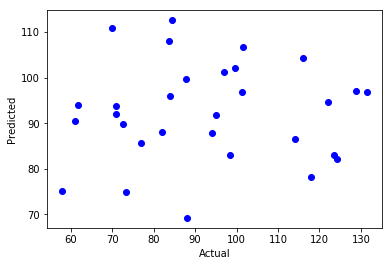

prediction accuracy: 0.0347 / p-value: 0.855385 / MSE: 542.342659 // Spearman: 0.073201 / p-value: 0.700670


In [24]:
if type_svm == 'nonbinary':
    # Perform the support vector classification
    from nilearn.input_data import NiftiMasker
    from sklearn.feature_selection import f_regression, SelectPercentile
    from sklearn.svm import SVR
    from sklearn.pipeline import Pipeline

    # Set up the regression
    svr = SVR(kernel='linear', C=1)
    masker = NiftiMasker(mask_img=gm_mask,standardize=True, 
                         memory='nilearn_cache', memory_level=1)
    
    feature_selection = SelectPercentile(f_regression, percentile=5)
    fs_svr = Pipeline([('feat_select', feature_selection), ('svr', svr)])
    
    # Run the regression
    X = masker.fit_transform(bold_feature_data)
    X = X[mask]
    maskedlabels=labels[mask]
    fs_svr.fit(X, maskedlabels)
        
    from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut

    loso = LeaveOneGroupOut()
    y_pred = cross_val_predict(fs_svr, X, y=maskedlabels, n_jobs=6,
                               groups=conditions['subject'][mask],cv=loso)
    # save weights
    coef = svr.coef_
    coef = feature_selection.inverse_transform(coef)
    coef_image = masker.inverse_transform(coef)
    coef_image.to_filename(output_dir + '/svrweights_' + analysis + '.nii.gz')
    
    ages_df = conditions[mask]
    ages_df['pred_age'] = Series(y_pred, index=ages_df.index)
    ages_df.head()

    actual_age = ages_df.groupby(['subject'])['age'].mean()
    actual_age = actual_age.tolist()
    pred_age = ages_df.groupby(['subject'])['pred_age'].mean()
    pred_age = pred_age.tolist()

    from scipy.stats import linregress
    slope, intercept, r_val, p_val, stderr = linregress(actual_age, pred_age) 

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(actual_age, pred_age)
    
    from scipy.stats import spearmanr
    spear_r, spear_p = spearmanr(actual_age, pred_age)

    print("prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f" % (r_val, p_val, mse, spear_r, spear_p))

    # plot the predicted versus actual values
    import matplotlib.pyplot as plt
    plt.scatter(actual_age, pred_age, color='b')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.savefig(output_dir + '/scatter_pred_actual_mean_' + analysis + '_final.svg', transparent=True)
    plt.show()
    plt.close()

    results_file.write("MEAN prediction accuracy r-value: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n" % (r_val, p_val, mse, spear_r, spear_p))
    results_file.write('predicted: ' + str(pred_age) + '\n')
    results_file.write('actual: ' + str(actual_age) + '\n')


    actual_age = ages_df.groupby(['subject'])['age'].median()
    actual_age = actual_age.tolist()
    pred_age = ages_df.groupby(['subject'])['pred_age'].median()
    pred_age = pred_age.tolist()

    from scipy.stats import linregress
    slope, intercept, r_val, p_val, stderr = linregress(actual_age, pred_age) 
    
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(actual_age, pred_age)

    from scipy.stats import spearmanr
    spear_r, spear_p = spearmanr(actual_age, pred_age)

    print("prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f" % (r_val, p_val, mse, spear_r, spear_p))

    # plot the predicted versus actual values
    import matplotlib.pyplot as plt
    plt.scatter(actual_age, pred_age, color='b')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.savefig(output_dir + '/scatter_pred_actual_median_' + analysis + '_final.svg', transparent=True)
    plt.close()
    
    results_file.write("MEDIAN prediction accuracy r-value: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n" % (r_val, p_val, mse, spear_r, spear_p))
    results_file.write('predicted: ' + str(pred_age) + '\n')
    results_file.write('actual: ' + str(actual_age) + '\n')
    
    results_file.close()

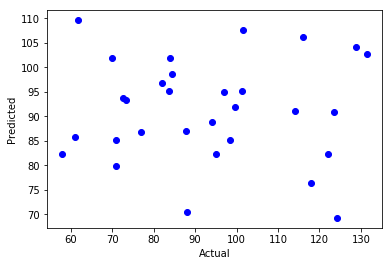

In [36]:
from scipy.stats import linregress
from numpy import asarray

# mean
pred_neg = asarray([102.77527199606482, 62.282288839024154, 84.84792372884402, 88.53460790282072, 80.68036401782568, 95.15312906084688, 95.72877557198402, 103.0601687413403, 55.445816976840604, 109.73230121701098, 108.0444948239525, 77.22675285622282, 118.62135846008408, 70.62714625430755, 78.6249659657542, 91.65401815504681, 72.76927651808263, 83.6388732573858, 95.17385323834006, 126.30395112291225, 114.07868865376781, 89.35357561923877, 88.56003230630894, 92.19968384408307, 81.5287923838048, 100.01267590932251, 92.02098557577199, 97.16267397703218, 89.5878375509027, 75.98751911490555])
pred_pos = asarray([111.24315728587766, 80.12307458481396, 98.5366847284252, 94.75507047715995, 80.43875747253594, 91.20321219706045, 76.92734741164001, 108.1169372710225, 70.1457445085356, 95.38643656983521, 107.42477293857614, 77.95133363858017, 90.86262318986095, 81.94893488537737, 82.84257860870724, 97.14909591347075, 78.1448290937317, 83.01007119315665, 99.83639121105718, 108.37844479236304, 102.23193267854725, 99.93199111488292, 102.7099827946621, 86.32757011090504, 92.1490007534008, 102.43743254322361, 85.42390737130464, 74.90951870426505, 84.83411422233428, 71.69693918468076])
pred_neu = asarray([104.39988376233798, 69.23518162922302, 101.28376792187744, 112.58723308841783, 99.62276156241623, 86.55433123901534, 82.98756469479886, 96.79740059124117, 82.18006459123502, 74.80986906573922, 97.05776822516893, 91.89874257244345, 95.98479999391225, 94.58419098508193, 93.76259819564086, 96.85188525469411, 78.13490567391808, 90.38914608887187, 110.79493714356435, 94.03148951589701, 106.74012697770209, 83.08913621353209, 89.90466447098379, 87.93488913710216, 102.21964105513949, 88.07193201411772, 108.02576134296758, 75.02622160891195, 85.71308051881238, 92.1052384780274])

# median
#pred_neg = asarray([101.67513569515603, 62.21336724274194, 85.0558907552695, 88.89416431932177, 77.00256014076419, 93.88222059569348, 91.00682716632474, 101.72641831145086, 54.77296768213391, 110.04969580552476, 109.02263984647772, 80.47702837638637, 121.31753657132776, 69.816286277487, 78.84064389082184, 87.22832309559735, 72.2064321163488, 84.13582135322729, 93.56587595203072, 130.98258468295214, 116.70598581414006, 88.95292479344101, 89.15956609081894, 92.8298473305295, 79.94545324440774, 104.07678691414748, 90.85733874633354, 93.80508850330045, 88.60478958609754, 73.60386285446015])
#pred_pos = asarray([111.24878889416752, 78.70299702028672, 95.79339855459015, 95.13226480501226, 80.69724922525884, 88.6989000159497, 76.06589420761404, 110.15411121144881, 71.67555402924387, 97.04252440183443, 107.40237338959284, 77.63266930092158, 90.39912968500884, 78.62045012783665, 82.04846123614232, 98.06261628747086, 76.02158155239513, 86.21323911934915, 99.94019197965457, 107.84101472956118, 105.04680672553494, 101.17921574134247, 100.62417975176584, 86.39037968976972, 95.72482492579314, 105.16615492342416, 85.43262140557756, 75.38311185606528, 86.37566351004509, 72.57167863745065])
#pred_neu = asarray([101.23351144215664, 70.20819724249577, 96.90847599122222, 110.3033373894802, 98.30943065001095, 89.00555255085496, 82.29967181161477, 97.75675492192399, 82.91865781773903, 78.550552048129, 97.59001609902336, 90.27061620278951, 93.57804778948791, 94.43049334709576, 92.12457806964628, 100.66523144431497, 74.33085735820342, 91.83423616700279, 104.20476821811545, 92.57395847312247, 109.02624822025538, 83.84858052857462, 93.55189582705447, 88.93520408310394, 103.24172244620027, 84.61829481477074, 112.83049217718045, 75.51549283819108, 90.35875356924608, 93.1247430859221])

actual = asarray([116.0, 88.0, 97.0, 84.5, 87.8, 114.0, 98.5, 131.4, 124.2, 73.4, 128.7, 95.0, 83.9, 122.1, 71.0, 101.4, 118.0, 61.0, 70.0, 61.7, 101.5, 123.4, 72.5, 94.0, 99.7, 82.0, 83.7, 58.0, 77.0, 71.0])

mean_pred = (pred_neg + pred_pos + pred_neu)/3

slope, intercept, r_val, p_val, stderr = linregress(actual, mean_pred)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, mean_pred)

from scipy.stats import spearmanr
spear_r, spear_p = spearmanr(actual, mean_pred)

results_file.write('MEAN prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n' % (r_val, p_val, mse, spear_r, spear_p))

# plot the predicted versus actual values
import matplotlib.pyplot as plt
plt.scatter(actual, mean_pred, color='b')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig(output_dir + '/scatter_pred_actual_mean.svg', transparent=True)
plt.show()
plt.close()

## Perform binary support vector classification

Classification accuracy: 0.7059 / Chance level: 0.500000


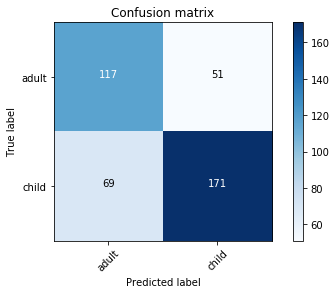

In [16]:
if type_svm == 'binary':
    # Perform the support vector classification
    from nilearn.input_data import NiftiMasker
    from sklearn.svm import SVC
    from sklearn.feature_selection import f_classif, SelectPercentile
    from sklearn.pipeline import Pipeline

    # Set up the support vector classifier
    svc = SVC(kernel='linear')
    masker = NiftiMasker(mask_img=gm_mask,standardize=True, 
                         memory='nilearn_cache', memory_level=1)
    
    # Select the features contributing to the model
    feature_selection = SelectPercentile(f_classif, percentile=5) #0.05/228453 voxels
    fs_svc = Pipeline([('feat_select', feature_selection), ('svc', svc)])

    # Run the classifier
    X = masker.fit_transform(bold_feature_data)
    X = X[mask]
    maskedlabels=labels[mask]
    fs_svc.fit(X, maskedlabels)
    
    # Obtain prediction values via cross validation
    from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_predict

    loso = LeaveOneGroupOut()
    cv_scores = cross_validate(fs_svc, X, y=maskedlabels, n_jobs=10, return_train_score=True,
                               groups=conditions['subject'][mask], cv=loso, scoring='accuracy')
    y_pred = cross_val_predict(fs_svc, X, y=maskedlabels, n_jobs=10,
                               groups=conditions['subject'][mask], cv=loso)
    
    ## Save the SVM weights to a nifti
    coef = svc.coef_
    coef = feature_selection.inverse_transform(coef)
    weight_img = masker.inverse_transform(coef)
    weight_img.to_filename(output_dir + '/svmweights_'+ analysis +'.nii.gz')
    
    ## Calculate performance metrics
    from sklearn.metrics import recall_score, precision_score
    
    classification_accuracy = cv_scores['test_score'].mean()
    chance = 1. / len(labels.unique())
    print("Classification accuracy: %.4f / Chance level: %f" % 
          (classification_accuracy, chance))
    
    for label in labels.unique():
        sensitivity = recall_score(maskedlabels,y_pred,labels=[label],average='weighted')
        precision = precision_score(maskedlabels,y_pred,labels=[label],average='weighted')
        
        results_file.write("%s: classification accuracy: %.4f / chance level: %f / sensitivity: %f / precision: %f \n" % 
        (label, classification_accuracy, chance, sensitivity, precision))
    
    # compute and display a confusion matrix
    from sklearn.metrics import confusion_matrix
    from numpy import set_printoptions
    import itertools
    import matplotlib.pyplot as plt

    cnf_matrix = confusion_matrix(maskedlabels, y_pred)
    set_printoptions(precision=2)
    classes = maskedlabels.unique()

    def plot_confusion_matrix(cm, classes):
        from numpy import arange
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j],  'd'),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    plot_confusion_matrix(cnf_matrix, classes)
    plt.savefig(output_dir + '/confusion_matrix_' + analysis + '.svg', transparent=True)
    
    results_file.close()

## Perform permutation testing to get a p-value for the classifier

In [ ]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from numpy import savetxt

results_file = open(output_dir + '/permut_results_' + analysis + '_final.txt','w')

if type_svm == 'binary':
    # Perform permutation testing to get a p-value
    score, permutation_scores, pvalue = permutation_test_score(fs_svc, X, maskedlabels, scoring='accuracy', 
                                                               cv=loso, n_permutations=500, n_jobs=10, 
                                                               groups=conditions['subject'][mask])
    savetxt(output_dir + '/permutation_scores_' + analysis + '.txt', permutation_scores)

    print("Classification score %s (pvalue : %s)" % (score, pvalue))
    # Save a figure of the permutation scores
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3,
             label='Classification Score (pvalue %f)' % pvalue)
    plt.plot(2 * [1. / len(labels.unique())], ylim, '--k', linewidth=3, label='Luck')
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.savefig(output_dir + '/permutation_plot_' + analysis + '.svg', transparent=True)
    plt.close()
    
    # save final pval/classifier score
    results_file.write("Classification score %s (pvalue : %s)" % (score, pvalue))
    results_file.close()

elif type_svm == 'nonbinary':
    ## Perform permutation testing to get a p-value for MSE
    score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, maskedlabels, scoring='neg_mean_squared_error', 
                                                               cv=loso, n_permutations=500, n_jobs=10, 
                                                               groups=conditions['subject'][mask])
    savetxt(output_dir + '/permutation_scores_mse_' + analysis + '.txt', permutation_scores)

    # Save a figure of the permutation scores
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3,
             label='Mean Squared Error (pvalue %f)' % pvalue)
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.savefig(output_dir + '/permutation_plot_mse_' + analysis + '.svg', transparent=True)
    plt.close()

    # save final pval/classifier score
    results_file.write('MSE score %s (pvalue : %s) \n' % (score, pvalue))
    
    ## Perform permutation testing to get a p-value for r-squared
    score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, maskedlabels, scoring='r2', 
                                                               cv=loso, n_permutations=500, n_jobs=10, 
                                                               groups=conditions['subject'][mask])
    savetxt(output_dir + '/permutation_scores_r2_' + analysis + '.txt', permutation_scores)

    # Save a figure of the permutation scores
    plt.hist(permutation_scores, 20, label='Permutation scores',
             edgecolor='black')
    ylim = plt.ylim()
    plt.plot(2 * [score], ylim, '--g', linewidth=3,
             label='R-squared (pvalue %f)' % pvalue)
    plt.ylim(ylim)
    plt.legend()
    plt.xlabel('Score')
    plt.savefig(output_dir + '/permutation_plot_r2_' + analysis + '.svg', transparent=True)
    plt.close()

    # save final pval/classifier score
    results_file.write('R square: %s (pvalue : %s) \n' % (score, pvalue))
    results_file.close()    